# **Análisis de riesgo por contaminación atmosférica**   
En este notebook se realiza el calculo y análisis del riesgo por contaminación atmosferica, teniendo como insumo la amenaza, la exposición y la vulnerabilidad.   
Esta clasificación de riesgo esta dada por bajo, moderado y alto.

Inicialmente se importan las librerias

In [19]:
import os
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

In [20]:
root_folder=r"/notebooks/Proyecto/Datos"

# Leer todos los datos
Municipio = root_folder+r"/Soacha.shp"

# Leer el archivo shapefile del municipio de Soacha
Soacha = gpd.read_file(Municipio)
Soacha = Soacha.to_crs(epsg=9377)
print("CRS Municipio de Soacha:", Soacha.crs)              
print(Soacha.head())

CRS Municipio de Soacha: EPSG:9377
  DPTO_CCDGO MPIO_CCDGO MPIO_CNMBR MPIO_CDPMP  VERSION          AREA  \
0         25        754     SOACHA      25754     2018  1.874460e+08   

    LATITUD  LONGITUD  STCTNENCUE  STP3_1_SI  ...  STP51_PRIM  STP51_SECU  \
0  4.537599 -74.22993    250494.0        0.0  ...    159931.0    296573.0   

   STP51_SUPE  STP51_POST  STP51_13_E  STP51_99_E  Shape_Leng  Shape_Area  \
0    115267.0      4977.0     11029.0     10427.0    0.913474    0.015275   

   Codigo_Mun                                           geometry  
0       25754  POLYGON ((4862589.466 2069855.794, 4862600.131...  

[1 rows x 92 columns]


**Calculo de riesgo por contaminación atmosferica**
En las siguientes celdas se lleva a cabo el calculo del riesgo por cada día de la semana, aplicando la siguiente ecuación:   
   
**Riesgo** = Amenaza * Exposición * ((Vulnerabilidad Uso Suelos * 0,5) + (Vulnerabilidad Centros Medicos * 0,5))    
    
El resultado de las operaciones anteriores se clasificaran de la siguiente manera:
* Riesgo bajo ---> Valores entre 1 y 9
* Riesgo Medio ---> Valores entre 10 y 18
* Riesgo Alto ---> Valores entre 19 y 27
  En la siguiente celda se realizara la calificación de estos valores


In [26]:
# Carpeta o dirección donde estan las raster
ruta_rasters= "/notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Raster/Reclasificados"

# Raster de amenaza por dia
DiasSemana = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] 
Riesgos_Diarios = {}
Riesgos_Clas = {}

# Raster de exposición y vulnerabilidades
with rasterio.open(os.path.join(ruta_rasters, "UsoSuelo_reclass.tif")) as src:
    exposicion = src.read(1)
    perfil = src.profile
    
with rasterio.open(os.path.join(ruta_rasters, "UsoSueloVul_reclass.tif")) as src:
    uso_vul = src.read(1)

with rasterio.open(os.path.join(ruta_rasters, "CentroSldVul_reclass.tif")) as src:
    salud_vul = src.read(1)

# Vulnerabilidad final
VulnerabilidadT = (uso_vul * 0.5 + salud_vul * 0.5).astype("float32")

perfil.update(dtype="float32")
perfil_clasificado = perfil.copy()
perfil_clasificado.update(dtype="uint8")

# Clasificar el riesgo de 1 a 3
def clasificar_riesgo(riesgo_array):
    clasificado = np.zeros_like(riesgo_array, dtype="uint8")
    clasificado[(riesgo_array >= 1) & (riesgo_array <= 9)] = 1
    clasificado[(riesgo_array > 9) & (riesgo_array <= 18)] = 2
    clasificado[(riesgo_array > 18)] = 3
    return clasificado

# Calcular riesgo para cada día
for dia in DiasSemana:
    path_amenaza = os.path.join(ruta_rasters, f"Amenaza_{dia}_clasificado.tif")

    with rasterio.open(path_amenaza) as src:
        amenaza = src.read(1)

    Riesgo = (amenaza * exposicion * VulnerabilidadT).astype("float32")

    out_riesgo = os.path.join(ruta_rasters, f"Riesgo_{dia}.tif")
    with rasterio.open(out_riesgo,
                       "w",
                       **perfil
                      )as dst:
        dst.write(Riesgo, 1)

    riesgo_class = clasificar_riesgo(Riesgo)
    Riesgos_Clas[dia] = riesgo_class

    out_riesgocla = os.path.join(ruta_rasters, f"Riesgo_{dia}_clasificado.tif")
    with rasterio.open(out_riesgocla, "w", **perfil_clasificado) as dst:
        dst.write(riesgo_class, 1)


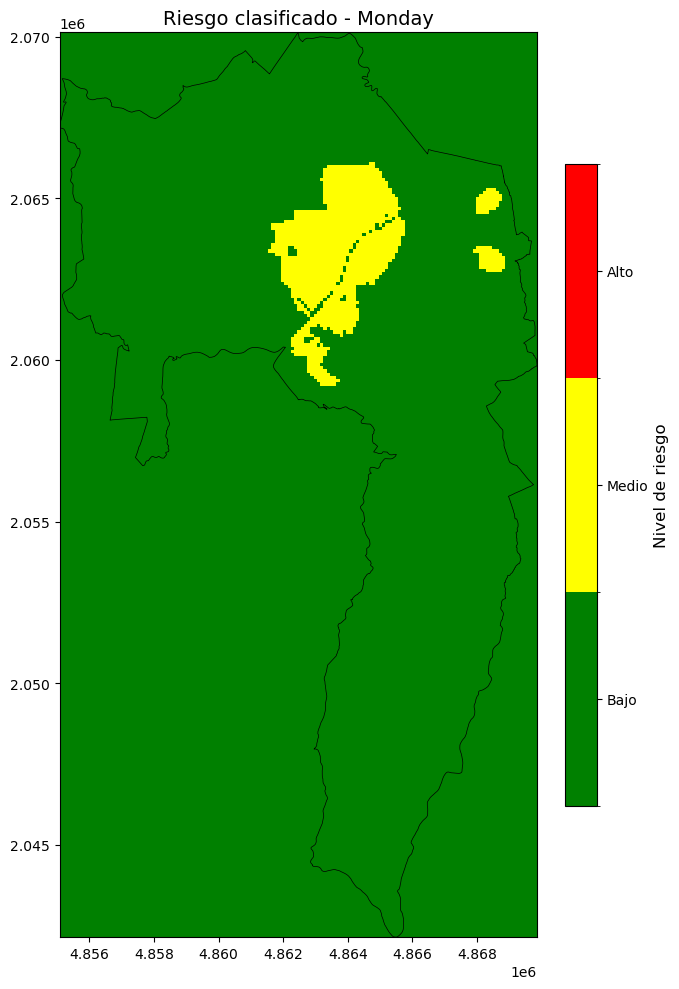

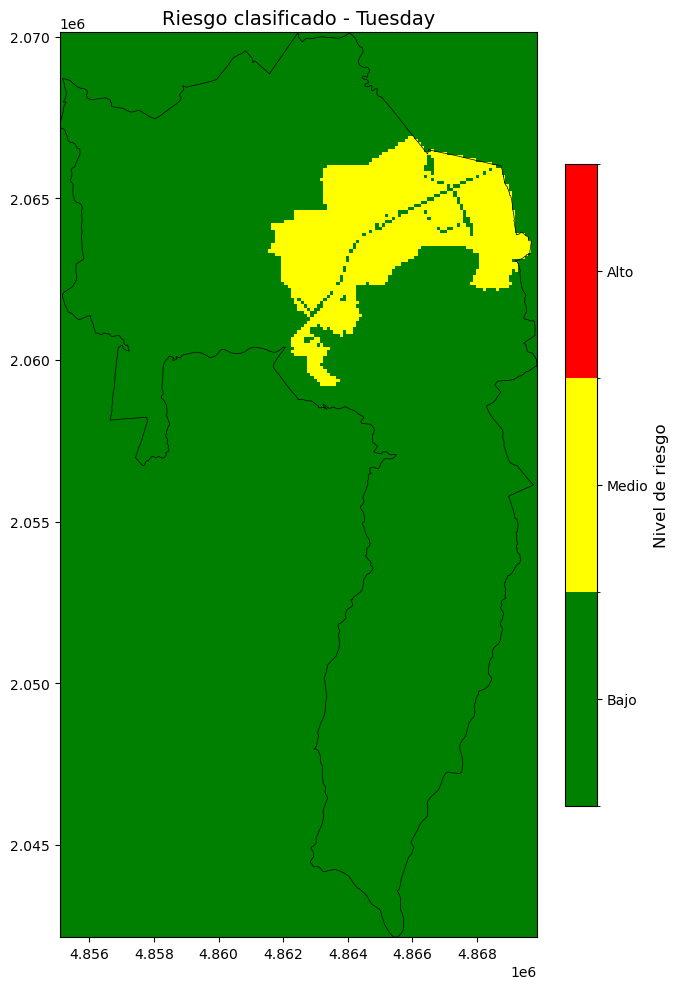

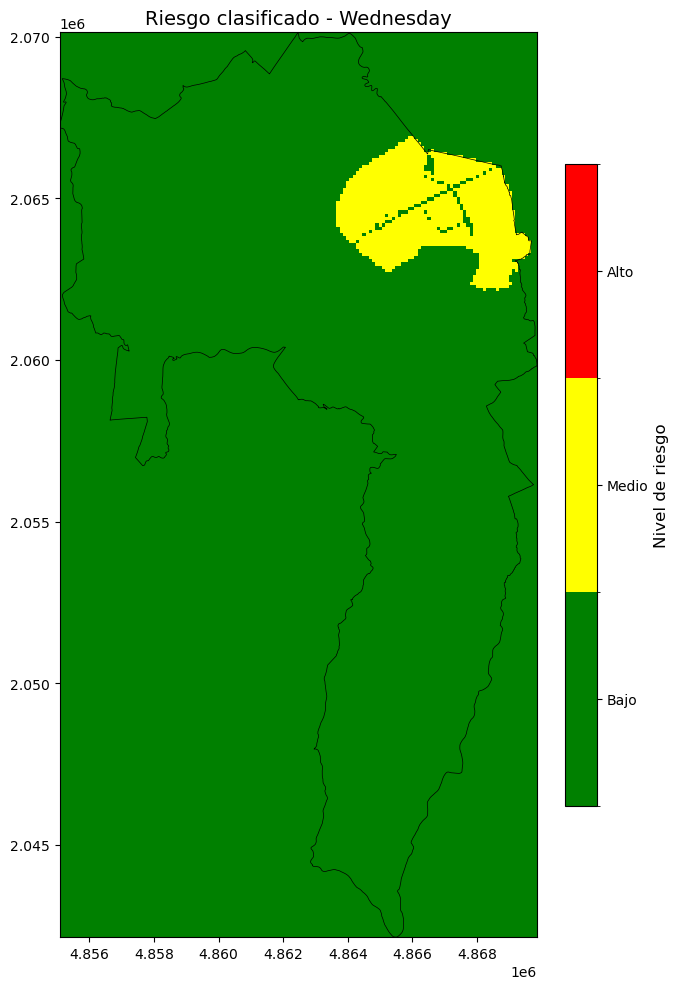

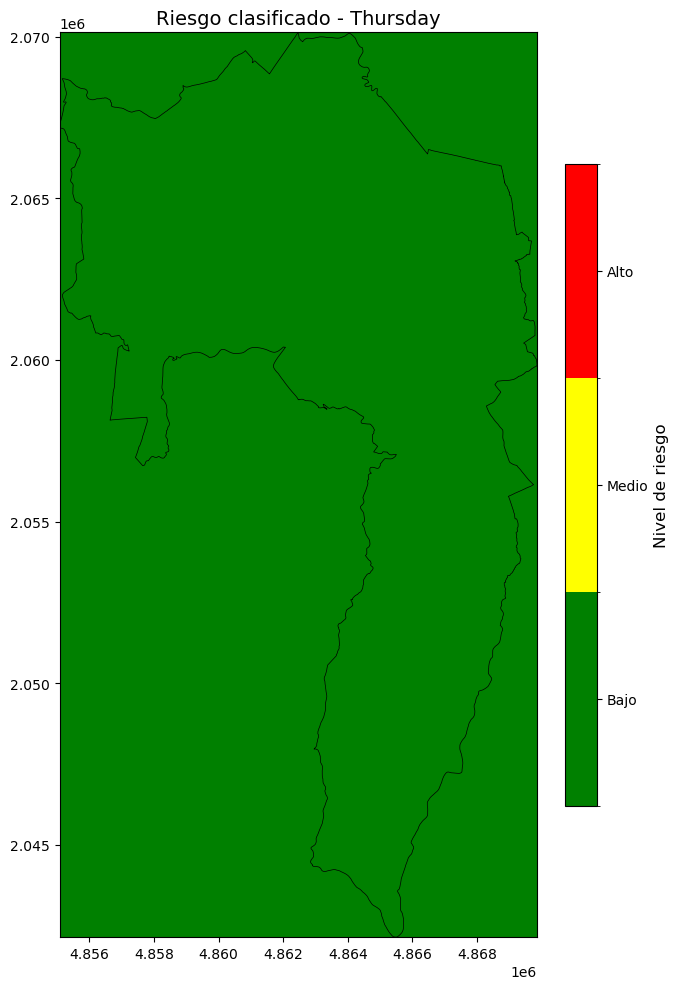

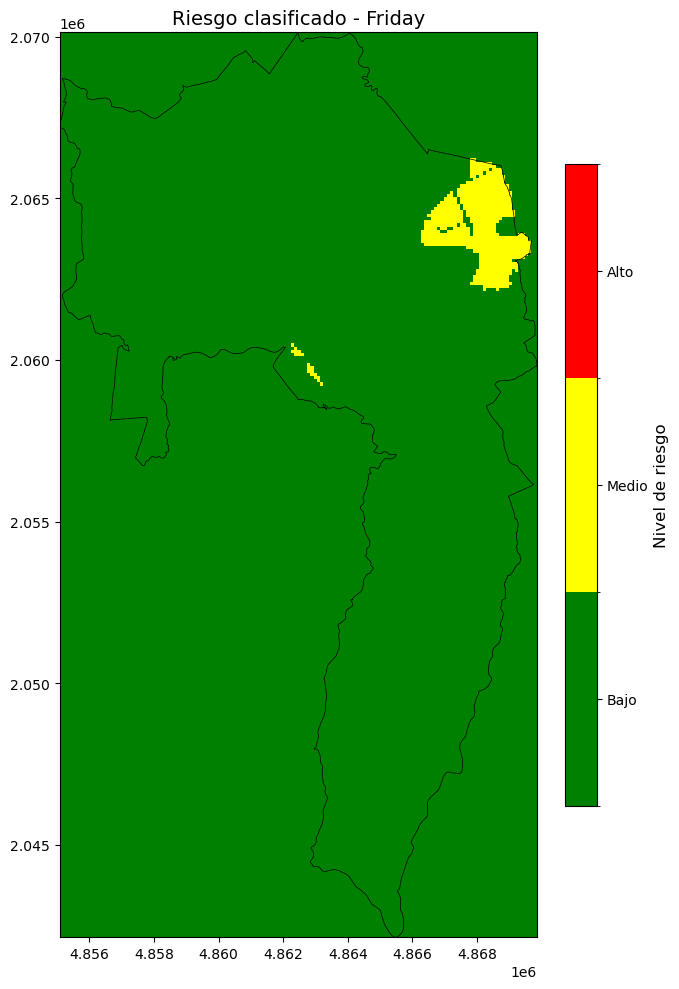

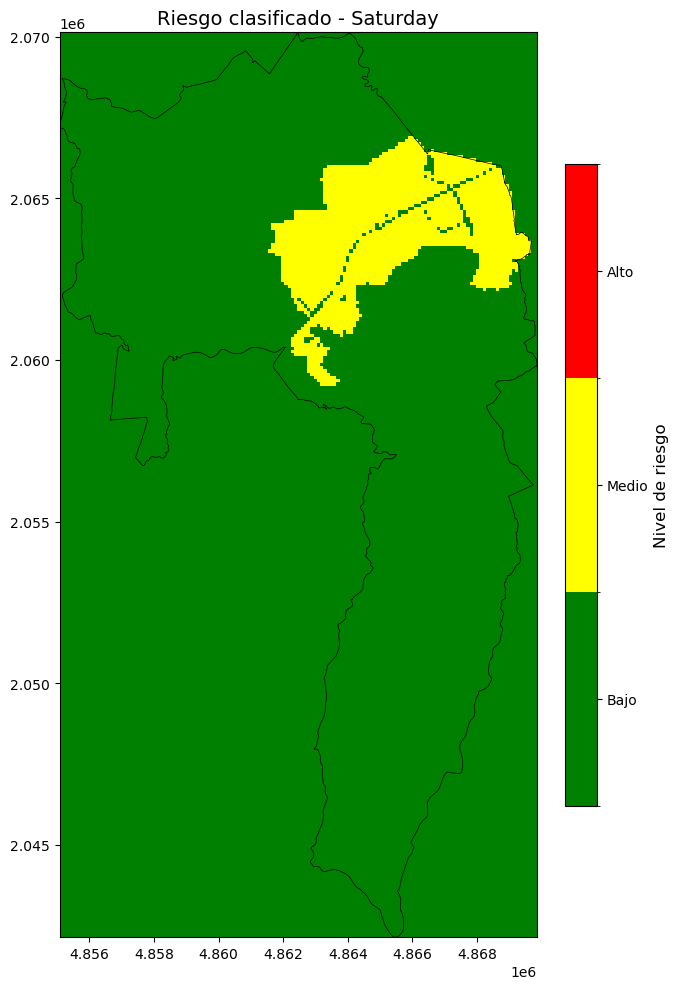

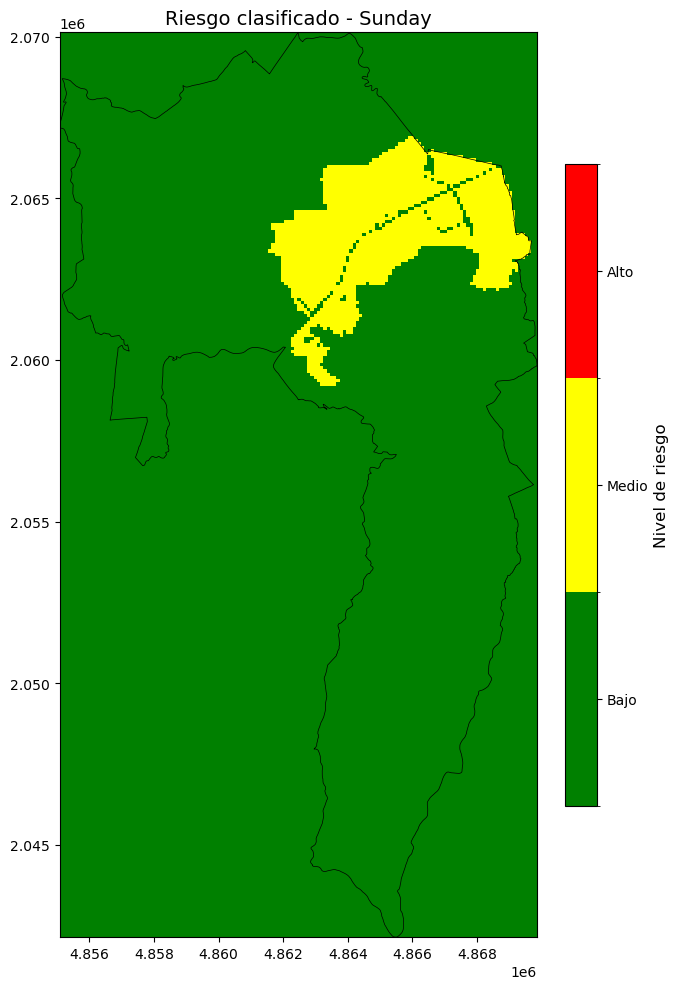

In [35]:
colores = ["green", "yellow", "red"]
cmap = ListedColormap(colores)
bounds = [0.5, 1.5, 2.5, 3.5]
norm = BoundaryNorm(bounds, cmap.N)

bounds = Soacha.total_bounds
extent = (bounds[0], bounds[2], bounds[1], bounds[3])

for dia in DiasSemana:
    riesgo_clasificado = Riesgos_Clas[dia]

    plt.figure(figsize=(8, 10))
    plt.title(f"Riesgo clasificado - {dia}", fontsize=14)
    
    plt.imshow(riesgo_clasificado, cmap=cmap, norm=norm, extent=extent)
    Soacha.boundary.plot(ax=plt.gca(), edgecolor='black', linewidth=0.5)
    
    cbar = plt.colorbar(ticks=[1, 2, 3], fraction=0.046, pad=0.04)
    cbar.ax.set_yticklabels(["Bajo", "Medio", "Alto"])
    cbar.set_label("Nivel de riesgo", fontsize=12)

    plt.axis()
    plt.tight_layout()  
    plt.savefig(f"/notebooks/Proyecto/Calidad_Aire_Soacha/Resultados/Riesgo_{dia}.png", dpi=300)
    plt.show()